In [1]:
import os
import random
import matplotlib.pyplot as plt
import tqdm

from bbchallenge import *

In [2]:
DB_PATH = "all_5_states_undecided_machines_with_global_header"

In [5]:
header = get_header(DB_PATH)
undecided_time, undecided_space, undecided_total, is_lex_sorted = int.from_bytes(header[:4],byteorder='big'),int.from_bytes(header[4:8],byteorder='big'),\
                                                                  int.from_bytes(header[8:12],byteorder='big'), header[12]
print(undecided_time, undecided_space, undecided_total, is_lex_sorted)

14322029 74342035 88664064 1


# Context

We want a heuristic to determine if a machine has a "ping-pong" behavior such as these ones:

## Unilateral pongs

5357965
s    0    1
---  ---  ---
A    1RB  0RD
B    1LC  1LE
C    1LD  1LB
D    0RA  1RD
E    ???  0RC


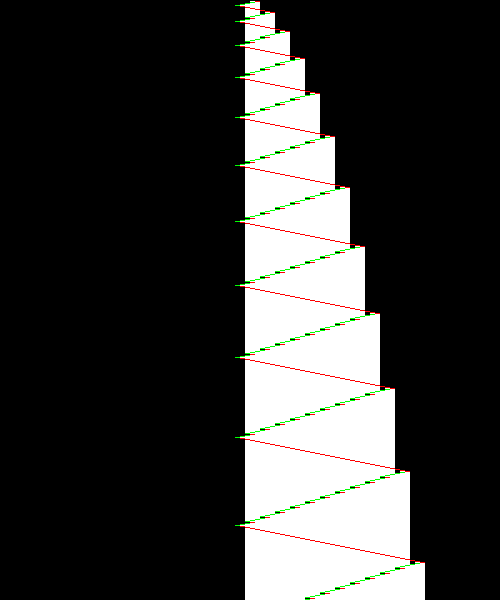

In [6]:
n = random.choice(zoo.unilateral_pongs)
print(n)
pptm(get_machine_i(DB_PATH,n))
img = tm_trace_to_image(get_machine_i(DB_PATH,n), origin=0.5, width=100, height=600, show_head_direction=True).resize((500,600), Image.NEAREST)
img

## Bilateral pongs

2488210
s    0    1
---  ---  ---
A    1RB  ???
B    1LB  0LC
C    1RD  1RC
D    0LE  1RE
E    1RC  1LE


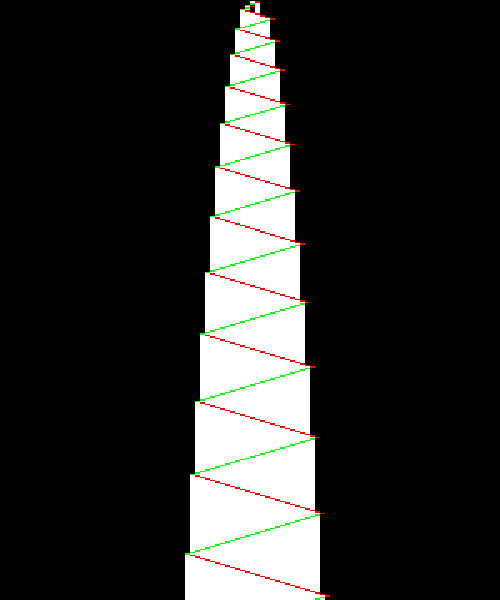

In [7]:
n = random.choice(zoo.bilateral_pongs)
print(n)
pptm(get_machine_i(DB_PATH,n))
img = tm_trace_to_image(get_machine_i(DB_PATH,n), origin=0.5, width=100, height=400, show_head_direction=True).resize((500,600), Image.NEAREST)
img

# Polynomial Passage Times Heuristic

We reason that the sequence of time steps at which the head is at cells that are relatively close to the origin must be polynomial. We care about relatively close cells to the origin because it means that the machine enters the polynomial behavior quickly. That constraint was found to be necessary for the heuristic to pass the tests on the examples and counter-examples we have.

Recognising polynomial sequences is not hard: the nth sequence of differences is null.

In [8]:
def simulate_and_get_passage_times(machine, time_limit = 100000):
    curr_time = 0
    curr_state = 0
    curr_pos = 0
    tape = {}
    passage_times = {}
    
    while curr_state != None and curr_time < time_limit:
        if not curr_pos in passage_times:
            passage_times[curr_pos] = []
        passage_times[curr_pos].append(curr_time)
        
        curr_state, curr_pos = step(machine, curr_state, curr_pos, tape)
        
        # Halt!
        if curr_state is None:
            return passage_times
        curr_time += 1
    
    return passage_times
        

In [9]:
def diff_n(l,n=1):
    lc = l[:]
    def diff(l):
        if len(l) < 2:
            return []
        to_ret = []
        for i in range(1,len(l)):
            to_ret.append(l[i]-l[i-1])
        return to_ret
    for i in range(n):
        lc = diff(lc)
    return lc

## Example n = 8541624

8541624
s    0    1
---  ---  ---
A    1RB  1RB
B    1LC  0LD
C    ???  1LD
D    0RA  1RE
E    1RA  1LC


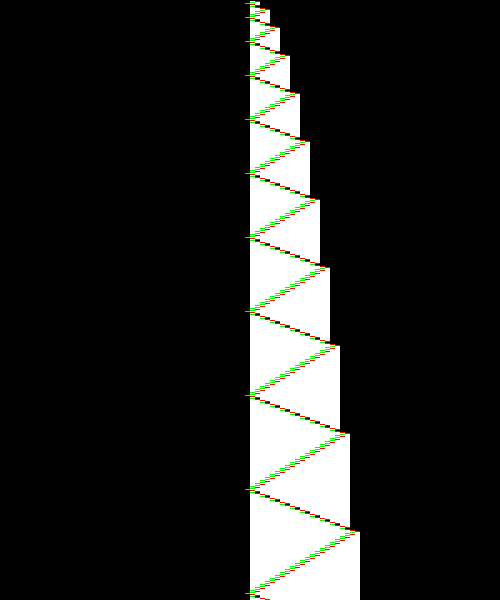

In [10]:
n = 8541624
print(n)
pptm(get_machine_i(DB_PATH,n))
img = tm_trace_to_image(get_machine_i(DB_PATH,n), origin=0.5, width=100, height=600, show_head_direction=True).resize((500,600), Image.NEAREST)
img

In [11]:
passing_times = simulate_and_get_passage_times(get_machine_i(DB_PATH,n))

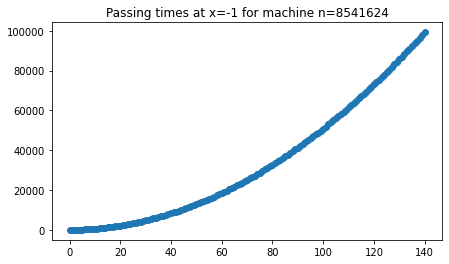

In [12]:
plt.figure(figsize=(7,4))
x=-1
plt.plot(passing_times[x], 'o')
plt.title(f"Passing times at x={x} for machine n={n}")
plt.show()

### The third differentiation is null (quadratic polynomial)
Except for small initial regime at the beginning. We require the 10 last entries to be 0.

In [13]:
print(passing_times[-1])

[3, 17, 41, 75, 119, 173, 237, 311, 395, 489, 593, 707, 831, 965, 1109, 1263, 1427, 1601, 1785, 1979, 2183, 2397, 2621, 2855, 3099, 3353, 3617, 3891, 4175, 4469, 4773, 5087, 5411, 5745, 6089, 6443, 6807, 7181, 7565, 7959, 8363, 8777, 9201, 9635, 10079, 10533, 10997, 11471, 11955, 12449, 12953, 13467, 13991, 14525, 15069, 15623, 16187, 16761, 17345, 17939, 18543, 19157, 19781, 20415, 21059, 21713, 22377, 23051, 23735, 24429, 25133, 25847, 26571, 27305, 28049, 28803, 29567, 30341, 31125, 31919, 32723, 33537, 34361, 35195, 36039, 36893, 37757, 38631, 39515, 40409, 41313, 42227, 43151, 44085, 45029, 45983, 46947, 47921, 48905, 49899, 50903, 51917, 52941, 53975, 55019, 56073, 57137, 58211, 59295, 60389, 61493, 62607, 63731, 64865, 66009, 67163, 68327, 69501, 70685, 71879, 73083, 74297, 75521, 76755, 77999, 79253, 80517, 81791, 83075, 84369, 85673, 86987, 88311, 89645, 90989, 92343, 93707, 95081, 96465, 97859, 99263]


In [14]:
print(diff_n(passing_times[x],0))

[3, 17, 41, 75, 119, 173, 237, 311, 395, 489, 593, 707, 831, 965, 1109, 1263, 1427, 1601, 1785, 1979, 2183, 2397, 2621, 2855, 3099, 3353, 3617, 3891, 4175, 4469, 4773, 5087, 5411, 5745, 6089, 6443, 6807, 7181, 7565, 7959, 8363, 8777, 9201, 9635, 10079, 10533, 10997, 11471, 11955, 12449, 12953, 13467, 13991, 14525, 15069, 15623, 16187, 16761, 17345, 17939, 18543, 19157, 19781, 20415, 21059, 21713, 22377, 23051, 23735, 24429, 25133, 25847, 26571, 27305, 28049, 28803, 29567, 30341, 31125, 31919, 32723, 33537, 34361, 35195, 36039, 36893, 37757, 38631, 39515, 40409, 41313, 42227, 43151, 44085, 45029, 45983, 46947, 47921, 48905, 49899, 50903, 51917, 52941, 53975, 55019, 56073, 57137, 58211, 59295, 60389, 61493, 62607, 63731, 64865, 66009, 67163, 68327, 69501, 70685, 71879, 73083, 74297, 75521, 76755, 77999, 79253, 80517, 81791, 83075, 84369, 85673, 86987, 88311, 89645, 90989, 92343, 93707, 95081, 96465, 97859, 99263]


In [15]:
print(diff_n(passing_times[x],3))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## Example n = 3405717

3405717
s    0    1
---  ---  ---
A    1RB  ???
B    1LC  1RE
C    0RB  1LD
D    1LB  0RB
E    1LB  0RD


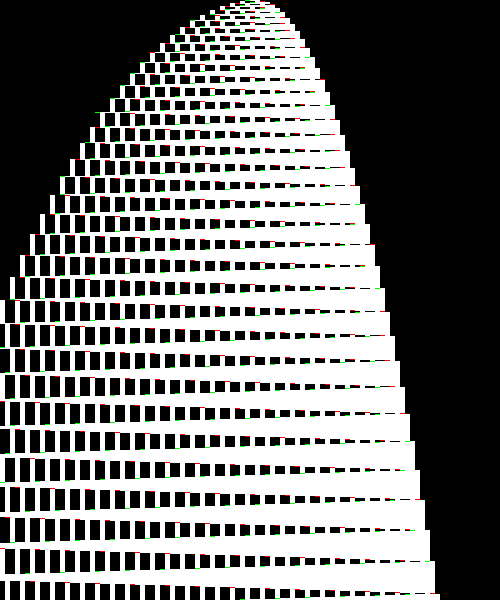

In [21]:
n = 3405717
print(n)
pptm(get_machine_i(DB_PATH,n))
img = tm_trace_to_image(get_machine_i(DB_PATH,n), origin=0.5, width=100, height=4000, show_head_direction=True).resize((500,600), Image.NEAREST)
img

In [22]:
passing_times = simulate_and_get_passage_times(get_machine_i(DB_PATH,n))

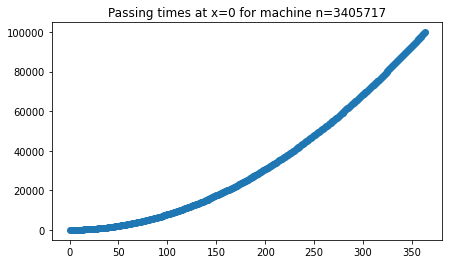

In [23]:
plt.figure(figsize=(7,4))
x=0
plt.plot(passing_times[x], 'o')
plt.title(f"Passing times at x={x} for machine n={n}")
plt.show()

In [24]:
print(diff_n(passing_times[x],3))

[-2, 0, -4, 8, -10, 12, -14, 16, -18, 20, -22, 24, -26, 28, -30, 32, -34, 36, -38, 40, -42, 44, -46, 48, -50, 52, -54, 56, -58, 60, -62, 64, -66, 68, -70, 72, -74, 76, -78, 80, -82, 84, -86, 88, -90, 92, -94, 96, -98, 100, -102, 104, -106, 108, -110, 112, -114, 116, -118, 120, -122, 124, -126, 128, -130, 132, -134, 136, -138, 140, -142, 144, -146, 148, -150, 152, -154, 156, -158, 160, -162, 164, -166, 168, -170, 172, -174, 176, -178, 180, -182, 184, -186, 188, -190, 192, -194, 196, -198, 200, -202, 204, -206, 208, -210, 212, -214, 216, -218, 220, -222, 224, -226, 228, -230, 232, -234, 236, -238, 240, -242, 244, -246, 248, -250, 252, -254, 256, -258, 260, -262, 264, -266, 268, -270, 272, -274, 276, -278, 280, -282, 284, -286, 288, -290, 292, -294, 296, -298, 300, -302, 304, -306, 308, -310, 312, -314, 316, -318, 320, -322, 324, -326, 328, -330, 332, -334, 336, -338, 340, -342, 344, -346, 348, -350, 352, -354, 356, -358, 360, -362, 364, -366, 368, -370, 372, -374, 376, -378, 380, -382, 3

## We sometimes have to consider subsequences

In practice our tests tuned the heuristic such that testing subsequences of the form `passing_times[::k]` for `k < 40` was enough.

In [25]:
print(diff_n(passing_times[x][::2],3))

[-6, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## Heuristic Code

In [26]:
def all_zero(l):
    for a in l:
        if a != 0:
            return False
    return True

In [27]:
def heuristic_polynomial_passage_times(machine, time_limit=1000000, 
                         nb_points_to_conclude = 10, 
                         max_time_begin_behavior=5, 
                         max_sampling_step = 40, debug=False):
    
    passage_times = simulate_and_get_passage_times(machine, time_limit=time_limit)

    for i in passage_times:
        for sampling_step in range(1,min(len(passage_times[i]),max_sampling_step)):
            subseq = passage_times[i][::sampling_step]
            third_derivative = diff_n(subseq,3)
            
            # enough points to conclude
            if len(third_derivative) >= nb_points_to_conclude:
                # the behavior started early enough
                if min(subseq) < max_time_begin_behavior:
                    # the last `nb_point_to_conclude` points of the third derivative are 0
                    if all_zero(third_derivative[-nb_points_to_conclude:]):
                        if debug:
                            print(i, sampling_step, len(third_derivative))
                        return True

    return False

# Testing the Heuristic

In [28]:
heuristic_polynomial_passage_times(get_machine_i(DB_PATH,3405717))

True

## Heuristic should say True

In [29]:
print(f"Testing {len(zoo.unilateral_pongs + zoo.bilateral_pongs)} machines")

Testing 134 machines


In [30]:
for n in tqdm.tqdm(zoo.unilateral_pongs + zoo.bilateral_pongs):
    if not heuristic_polynomial_passage_times(get_machine_i(DB_PATH,n)):
        print("Problem:", n)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [01:11<00:00,  1.87it/s]


## Heuristic should say False

In [32]:
print(f"Testing {len(zoo.translated_unilateral_pongs + zoo.exponential_counters + zoo.potential_halters + zoo.halters)} machines")

Testing 35 machines


In [34]:
for n in tqdm.tqdm(zoo.translated_unilateral_pongs + zoo.exponential_counters + zoo.potential_halters):
    if heuristic_polynomial_passage_times(get_machine_i(DB_PATH,n)):
        print("Problem:", n)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:46<00:00,  1.67s/it]


In [35]:
for machine in tqdm.tqdm(zoo.halters):
    if heuristic_polynomial_passage_times(machine):
        print("Problem:", n)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.99it/s]


# Results

On Feb 23rd 2022, `1,964,275` machines passed the heuristic (out of `2,322,122` remaining undecided machines).